In [1]:
import tensorflow as tf 
from tensorflow.keras import  models , layers
import matplotlib.pyplot as plt

In [2]:
height = 256
width = 256

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
     "Train",
     shuffle = True,
     image_size = (height,width),
     batch_size =  20
     
)

Found 1322 files belonging to 3 classes.


In [4]:
class_names =  dataset.class_names
class_names

['Healthy', 'Powdery', 'Rust']

In [5]:
len(dataset)

67

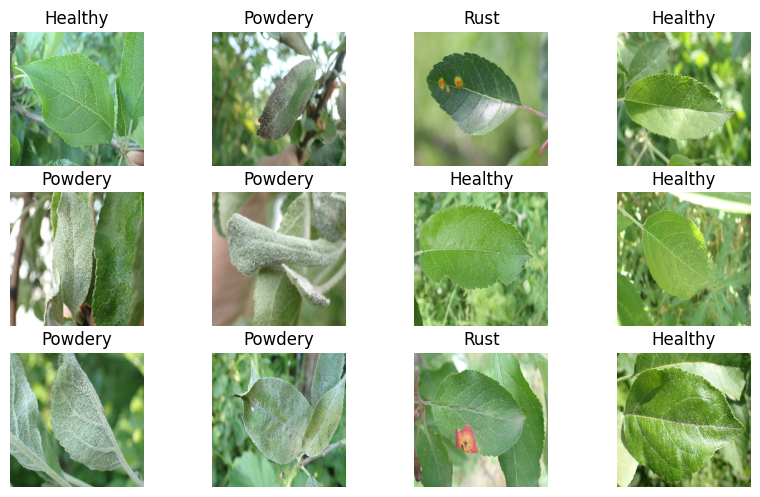

In [6]:
plt.figure(figsize=(10,8))
for  image_batch , label_batch in dataset.take(1):
     resized_images = tf.image.resize(image_batch, [256, 256])
     for i in range(12):
          ax= plt.subplot(4,4,i+1)
          plt.imshow(resized_images[i].numpy().astype('uint8'))
          plt.title(class_names[label_batch[i]])
          plt.axis('off')
          

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, Shuffle=True, Shuffle_size=1000):
    ds_size = len(ds)
    
    if Shuffle:
        ds = ds.shuffle(buffer_size=Shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, test_ds, val_ds


In [15]:
train_ds,test_ds,val_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)


53

In [17]:
len(test_ds)

8

In [18]:
len(val_ds)

6

In [19]:
train_ds1 =  train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds1 =  val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds1 =  test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale =tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(256,256),
     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:

data_augmentation =  tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
from tensorflow.keras import layers

input_shape = (20, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    # Assuming resize_and_rescale and data_augmentation are defined somewhere
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (20, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (20, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (20, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (20, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (20, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (20, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
import tensorflow as tf

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)


In [27]:
model_history = model.fit(train_ds1,validation_data= val_ds,batch_size=20,epochs=20,callbacks=early_stopping)

Epoch 1/20


53/53 [==============================] - 61s 1s/step - loss: 0.2863 - accuracy: 0.9002 - val_loss: 0.3874 - val_accuracy: 0.9167
Epoch 2/20
53/53 [==============================] - 70s 1s/step - loss: 0.2241 - accuracy: 0.9203 - val_loss: 0.0725 - val_accuracy: 0.9833
Epoch 3/20
53/53 [==============================] - 62s 1s/step - loss: 0.2815 - accuracy: 0.8954 - val_loss: 0.0680 - val_accuracy: 0.9902
Epoch 4/20
53/53 [==============================] - 58s 1s/step - loss: 0.1587 - accuracy: 0.9511 - val_loss: 0.5027 - val_accuracy: 0.8750
Epoch 5/20
53/53 [==============================] - 57s 1s/step - loss: 0.2537 - accuracy: 0.9203 - val_loss: 0.2999 - val_accuracy: 0.9000
Epoch 6/20
53/53 [==============================] - 57s 1s/step - loss: 0.1567 - accuracy: 0.9501 - val_loss: 0.0573 - val_accuracy: 0.9833
Epoch 7/20
53/53 [==============================] - 57s 1s/step - loss: 0.1344 - accuracy: 0.9559 - val_loss: 0.1363 - val_accuracy: 0.9583
Epoch 8/20
53/53 [=============

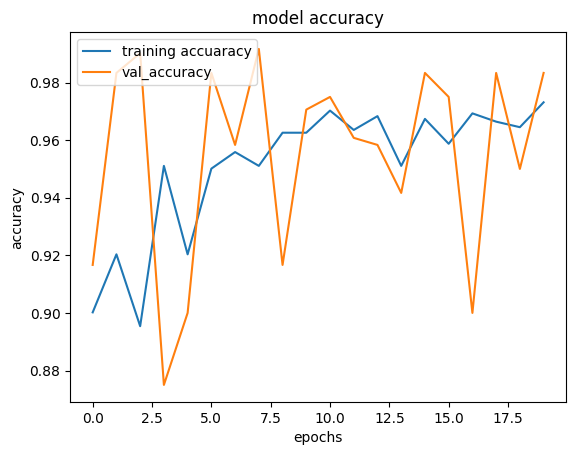

In [28]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training accuaracy','val_accuracy'],loc =  'upper left')
plt.show()

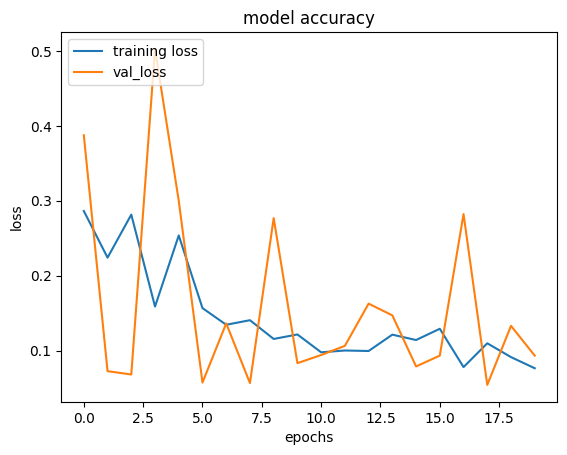

In [29]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss','val_loss'],loc =  'upper left')
plt.show()

first image predicted


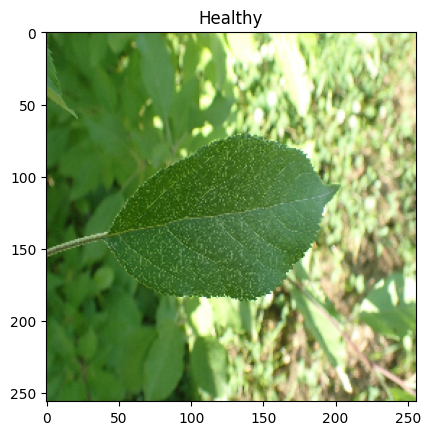

In [30]:
for image_batch,label_batch in test_ds1.take(1):
     first_image =  image_batch[0].numpy().astype('uint8')
     first_label =  label_batch[0].numpy()
     print("first image predicted")
     plt.imshow(first_image)
     plt.title(class_names[first_label])

first image predicted
1/1 [==============================] - 1s 782ms/step
predicted label Healthy


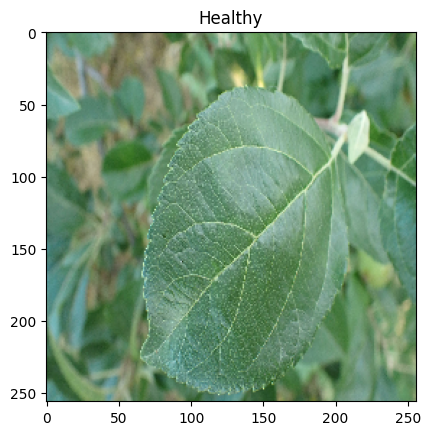

In [31]:
import numpy as np
for image_batch,label_batch in test_ds1.take(1):
     first_image =  image_batch[0].numpy().astype('uint8')
     first_label =  label_batch[0].numpy()
     print("first image predicted")
     plt.imshow(first_image)
     plt.title(class_names[first_label])
     
     batch_pred =  model.predict(image_batch)
     print("predicted label",class_names[np.argmax(batch_pred[2])])
     
     
     

In [32]:
def predict(model, image, class_names):
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)
    prediction = model.predict(image_array)
    
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    
    return prediction_class, confidence


1/1 [==============================] - 0s 54ms/step


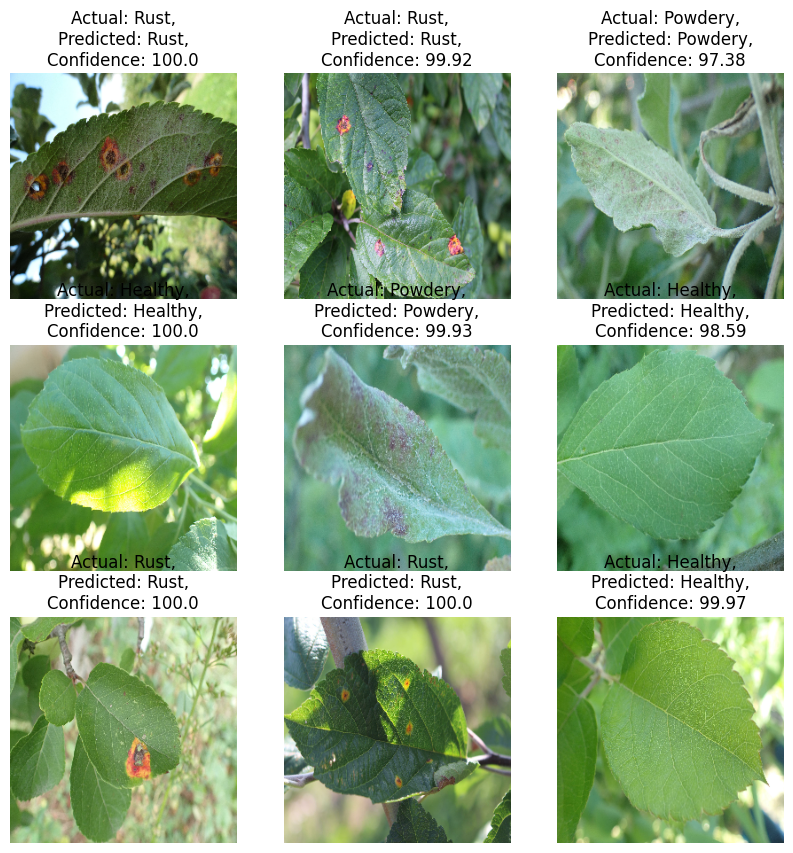

In [33]:
plt.figure(figsize=(10, 10))
for image, label in test_ds1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))
        prediction_class, confidence = predict(model, image[i].numpy(), class_names)
        actual_class = class_names[label[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {prediction_class},\nConfidence: {confidence}")
        plt.axis('off')


In [37]:
model_version = 2
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/2\assets


INFO:tensorflow:Assets written to: ../model/2\assets


In [38]:
import os

In [ ]:
os.listdir("../model")

['1', '2']